In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import math

(214, 187, 3)


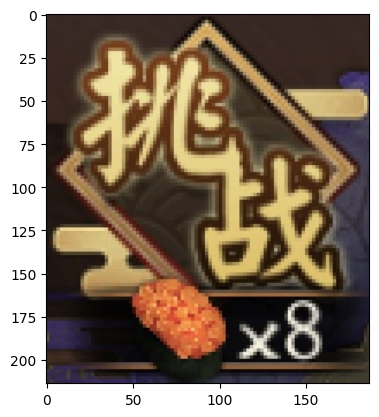

In [3]:
img_t = cv.imread("../pics/03-T.jpg")
img_t = cv.cvtColor(img_t, cv.COLOR_BGR2RGB)
# img_t = cv.resize(img_t, [128, 128])
# img_t = cv.resize(img_t, [256, 256])
print(img_t.shape)
plt.imshow(img_t)